<a href="https://colab.research.google.com/github/hyewwn/2023-summer-internship-DSAIL/blob/main/implicit_mf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implicit matrix factorization model implementation

## package import & drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import math
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## data loading and train, test split

In [ ]:
path = '/content/drive/MyDrive/DSAIL/'
file_name = 'preped_music_play.csv'

In [ ]:
# full data loading
data = pd.read_csv(path+file_name).iloc[:,1:]

In [ ]:
data.head()

,userID,artistNM,plays
0,1,bloc party,1677
1,1,radiohead,1287
2,1,the mars volta,1024
3,1,at the drive-in,866
4,1,misfits,642


In [ ]:
data.nunique()

userID       100
artistNM    7257
plays        792
dtype: int64

In [ ]:
# 각 userID 별로 행 인덱스를 그룹화하여 리스트로 저장
grouped_indices = data.groupby('userID').groups.values()

# 각 그룹의 행 인덱스를 80:20 비율로 분할하여 train과 test indices 구성
train_indices = []
test_indices = []
for i, indices in enumerate(grouped_indices):
    train_group_indices, test_group_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_indices.extend(train_group_indices)
    test_indices.extend(test_group_indices)

# train_df와 test_df 생성
train_df = data.loc[train_indices]
test_df = data.loc[test_indices]

print("Train DataFrame:")
print(train_df.shape)
print("Test DataFrame:")
print(test_df.shape)

Train DataFrame:
(8856, 3)
Test DataFrame:
(2269, 3)


## setting

In [ ]:
lambda_ = 150
alpha_ = 40
epsilon_ = 10**(-8)
n_factor = 100

### matrix creation function

In [ ]:
# R matrix (observation matrix)

def create_R_matrix(df, train_set):
    # 모든 고유한 userID와 artistNM을 추출
    all_userIDs = np.unique((df['userID'].unique()))
    all_artistNMs = np.unique((df['artistNM'].unique()))

    # 행렬 초기화
    plays_matrix = pd.DataFrame(0, index=all_userIDs, columns=all_artistNMs)

    # train set에 있는 데이터로 행렬 채우기
    for _, row in train_set.iterrows():
        userID = row['userID']
        artistNM = row['artistNM']
        plays = row['plays']
        plays_matrix.loc[userID, artistNM] = plays

    return plays_matrix

In [ ]:
# P_matrix (preference)
def create_P_matrix(R_matrix):
    P_matrix = np.copy(R_matrix)
    P_matrix[R_matrix>0] = 1
    return P_matrix

In [ ]:
# C matrix (confidence)
def create_C_matrix(R_matrix):
    C_matrix = 1 + alpha_*np.log(1+R_matrix/epsilon_)
    C_matrix = np.array(C_matrix)
    return C_matrix

### matrix creation and initialization

In [ ]:
# create_R_matrix 함수 실행
R_matrix = create_R_matrix(data, train_df)
print(R_matrix.shape)

(100, 7257)


In [ ]:
# create_P_matrix 함수 실행
P_matrix = create_P_matrix(R_matrix)
print(P_matrix.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(100, 7257)


In [ ]:
# create_C_matrix 함수 실행
C_matrix = create_C_matrix(R_matrix)
print(C_matrix.shape)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
(100, 7257)


In [ ]:
# number of user and item
m = R_matrix.shape[0]
n = R_matrix.shape[1]

# user-factor matrix initialize
X = np.random.rand(m, n_factor) * 0.01
print(X.shape)

# item-factor matrix initialize
Y = np.random.rand(n, n_factor) * 0.01
print(Y.shape)

(100, 100)
(7257, 100)


## Loss function

In [ ]:
def loss_function(C, P, pred, X, Y, lambda_):
    predict_error = np.square(P-pred)
    confidence_error = np.sum(C*predict_error)
    regularization_error = lambda_*(np.sum(np.square(X))+np.sum(np.square(Y)))
    total_loss = confidence_error + regularization_error
    return np.sum(predict_error), confidence_error, regularization_error, total_loss

## Optimizer (ALS algorithm)

In [ ]:
def user_optimization(X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_):
    yT = np.transpose(Y)
    yTy = np.matmul(yT, Y)
    for user in range(m):
        Cu = np.diag(C_matrix[user])
        yT_Cu_y = yTy + np.matmul(np.matmul(yT, Cu - np.identity(n)),Y)
        lambda_I = lambda_ * np.identity(n_factor)
        yT_Cu_pu = np.matmul(np.matmul(yT,Cu), np.transpose(P_matrix[user]))
        X[user] = np.linalg.solve(yT_Cu_y+lambda_I, yT_Cu_pu)

In [ ]:
def item_optimization(X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_):
    xT = np.transpose(X)
    xTx = np.matmul(xT, X)
    for item in range(n):
        Ci = np.diag(C_matrix[:,item])
        xT_Ci_x = xTx + np.matmul(np.matmul(xT, Ci - np.identity(m)),X)
        lambda_I = lambda_ * np.identity(n_factor)
        xT_Ci_pi = np.matmul(np.matmul(xT,Ci), np.transpose(P_matrix[:,item]))
        Y[item] = np.linalg.solve(xT_Ci_x+lambda_I, xT_Ci_pi)

## Train function

In [ ]:
n_iter = 10

In [ ]:
def train(n_iter,X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_):
    # result save
    predict_errors = []
    confidence_errors = []
    regularization_list = []
    total_losses = []

    for i in range(n_iter):
        print(f'processing on {i+1}th iteration')
        if i != 0:
            user_optimization(X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_)
            item_optimization(X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_)

        predict = np.matmul(X, np.transpose(Y))

        predict_error, confidence_error, regularization, total_loss = loss_function(C_matrix, P_matrix, predict, X, Y, lambda_)

        predict_errors.append(predict_error)
        confidence_errors.append(confidence_error)
        regularization_list.append(regularization)
        total_losses.append(total_loss)

        print(f'{i+1}th iteration is done')

    fin_predict = np.matmul(X, np.transpose(Y))
    print('final predict')
    print([fin_predict])
    return fin_predict, predict_errors, confidence_errors, regularization_list, total_losses


In [ ]:
train_pred, predict_errors, confident_errors, regularization_list, total_losses = train(n_iter,X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_)

## Training Results
predict_errors, confident_errors, regularization_list, total_losses

In [ ]:
# predict_errors
x_axis = np.arange(1,11)
y_axis = predict_errors
plt.plot(x_axis, y_axis)
plt.xticks([i for i in range(1,11)])
plt.xlabel("iteration")
plt.title("predict error")
plt.show()

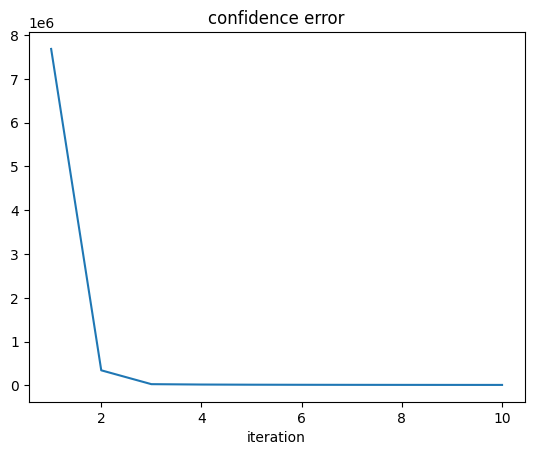

In [ ]:
# confident_errors
x_axis = np.arange(1,11)
y_axis = confident_errors
plt.plot(x_axis, y_axis)
plt.xlabel("iteration")
plt.title("confidence error")
plt.show()

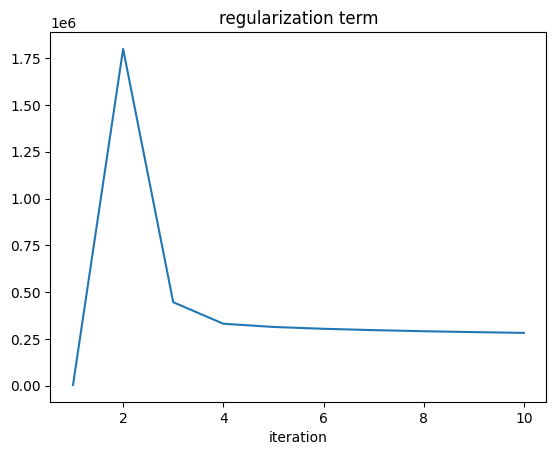

In [ ]:
# regularization_list
x_axis = np.arange(1,11)
y_axis = regularization_list
plt.plot(x_axis, y_axis)
plt.xlabel("iteration")
plt.title("regularization term")
plt.show()

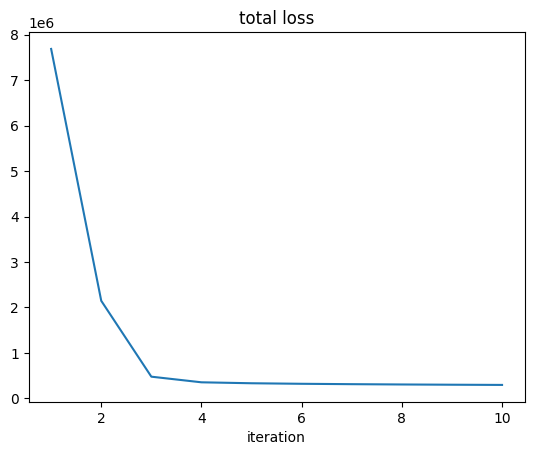

In [ ]:
# total_losses
x_axis = np.arange(1,11)
y_axis = total_losses
plt.plot(x_axis, y_axis)
plt.xlabel("iteration")
plt.title("total loss")
plt.show()

## Test set Evaluation

In [ ]:
final_predict_df = pd.DataFrame(train_pred)

In [ ]:
all_userIDs = np.unique((data['userID'].unique()))
all_artistNMs = np.unique((data['artistNM'].unique()))

final_predict_df.index = all_userIDs
final_predict_df.columns = all_artistNMs

## calculate expected percentile ranking

In [ ]:
def calculate_percentile_ranks(input_list):
    sorted_values = sorted(input_list)
    ranks = [1 - (sorted_values.index(value) / (len(sorted_values) - 1)) for value in input_list]
    return ranks

In [ ]:
def calculate_rank(predict_df, R_matrix, train_set, test_set):

  # 1. predict_df에서 0.5 미만 값을 갖는 경우 모두 0으로 변환
  predict_df[predict_df < 0.5] = 0

  # 2. rank_matrix 구성 (size는 predict_df와 동일)
  rank_matrix = predict_df.copy()

  # predict_df에서 train에 포함된 데이터의 경우 값을 모두 0으로 처리
  train_indices = [(row, col) for row, col in train_set[['userID', 'artistNM']].values]
  rank_matrix[train_indices] = 0

  # user(row)별로 값이 0이 아닌 데이터들에 대해 percentile rank를 계산하여 값 변환
  for row in rank_matrix.index:
    nonzero_indices = rank_matrix.columns[rank_matrix.loc[row] != 0].tolist()
    if len(nonzero_indices) > 0:
      tmp_col_list = rank_matrix.loc[row, nonzero_indices].tolist()
      tmp_qua_list = calculate_percentile_ranks(tmp_col_list)
      rank_matrix.loc[row, nonzero_indices] = np.array(tmp_qua_list)

  # 3. R_test_matrix 구성
  R_test_matrix = R_matrix.copy()

  # R_matrix에서 train에 포함된 데이터의 경우 값을 모두 0으로 처리
  train_indices = [(row, col) for row, col in train_set[['userID', 'artistNM']].values]
  R_test_matrix[train_indices] = 0

  # 4. rank_bar 계산 (expected percentile ranking)
  rt = np.array(R_test_matrix)
  rank = np.array(rank_matrix)
  rt_rank = rt*rank
  numerator = np.sum(rt_rank)
  denominator = np.sum(rt)
  rank_bar = numerator/denominator
  print(rank_bar)
  return rank_bar

In [ ]:
rank_bar = calculate_rank(final_predict_df, R_matrix, train_df, test_df)

0.26784734475039357


## Experiment

In [ ]:
lambda_ = 150
alpha_ = 40
epsilon_ = 10**(-8)
n_factor = 100

In [ ]:
def experiment(data, train_df, test_df, n_factor, n_iter, lambda_=150, alpha_=40, epsilon_=10**(-8)):
  # matrix creation
  R_matrix = create_R_matrix(data, train_df)
  P_matrix = create_P_matrix(R_matrix)
  C_matrix = create_C_matrix(R_matrix)

  # number of user and item
  m = R_matrix.shape[0]
  n = R_matrix.shape[1]
  # user-factor matrix initialize
  X = np.random.rand(m, n_factor) * 0.01
  # item-factor matrix initialize
  Y = np.random.rand(n, n_factor) * 0.01

  # training
  train_pred, predict_errors, confident_errors, regularization_list, total_losses = train(n_iter,X, Y, C_matrix, P_matrix, m, n, n_factor, lambda_)

  # training results
  final_predict_df = pd.DataFrame(train_pred)
  all_userIDs = np.unique((data['userID'].unique()))
  all_artistNMs = np.unique((data['artistNM'].unique()))
  final_predict_df.index = all_userIDs
  final_predict_df.columns = all_artistNMs

  # test results
  rank_bar = calculate_rank(final_predict_df, R_matrix, train_df, test_df)

  return final_predict_df, predict_errors, confident_errors, regularization_list, total_losses, rank_bar


### Experiment1: change number of factors

In [ ]:
factor_list = [i for i in range(20,201,20)]
print(factor_list)

[20, 40, 60, 80, 100, 120, 140, 160, 180, 200]


In [ ]:
# 결과 저장용 list 생성
rank_bar_factors = []

In [ ]:
for i in range(10):
  n_factor = factor_list[i]
  tmp_final_predict_df, tmp_predict_errors, tmp_confident_errors, tmp_regularization_list, tmp_total_losses, tmp_rank_bar = experiment(data, train_df, test_df, n_factor, n_iter=10, lambda_=150, alpha_=40, epsilon_=10**(-8))
  globals()['final_predict_df_{}'.format(i)] = tmp_final_predict_df
  globals()['predict_errors_{}'.format(i)] = tmp_predict_errors
  globals()['confident_errors_{}'.format(i)] = tmp_confident_errors
  globals()['regularization_list_{}'.format(i)] = tmp_regularization_list
  globals()['total_losses_{}'.format(i)] = tmp_total_losses
  globals()['rank_bar_{}'.format(i)] = tmp_rank_bar

  # rank_bar는 따로 저장
  rank_bar_factors.append(tmp_rank_bar)

  print(f'-----------{i+1}th iteration is done-------------')

processing on 1th iteration
1th iteration is done
processing on 2th iteration
2th iteration is done
processing on 3th iteration
3th iteration is done
processing on 4th iteration
4th iteration is done
processing on 5th iteration
5th iteration is done
processing on 6th iteration
6th iteration is done
processing on 7th iteration
7th iteration is done
processing on 8th iteration
8th iteration is done
processing on 9th iteration
9th iteration is done
processing on 10th iteration
10th iteration is done
final predict
[array([[ 1.04007056,  0.09602621, -0.00541847, ...,  0.        ,
        -0.2258952 ,  0.        ],
       [ 0.41545324,  0.02212591, -0.14241127, ...,  0.        ,
         0.19153022,  0.        ],
       [ 0.39895165, -0.02985879,  0.01162843, ...,  0.        ,
        -0.18751178,  0.        ],
       ...,
       [-0.18510184,  0.26710479, -0.17167623, ...,  0.        ,
        -0.09909377,  0.        ],
       [ 0.51136124, -0.10289595,  0.28433269, ...,  0.        ,
      

In [ ]:
print(rank_bar_factors)

[0.1323974836227368, 0.21828247670752926, 0.25044777206322955, 0.2659941166772065, 0.26523462215080984, 0.271588774958885, 0.26874180343157866, 0.2679842968241854, 0.268448852927668, 0.2680723733297802]


#### factor change graph

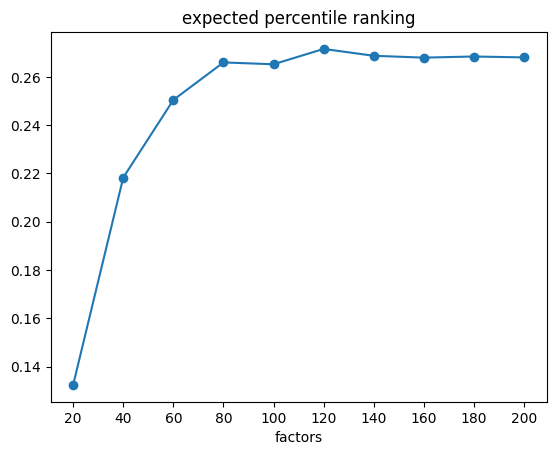

In [ ]:
x_axis = [i for i in range(20,201,20)]
y_axis = rank_bar_factors
plt.plot(x_axis, y_axis, marker='o')
plt.xticks([i for i in range(20,201,20)])
plt.xlabel("factors")
plt.title("expected percentile ranking")
plt.show()

#### loss function (n_factor=20)

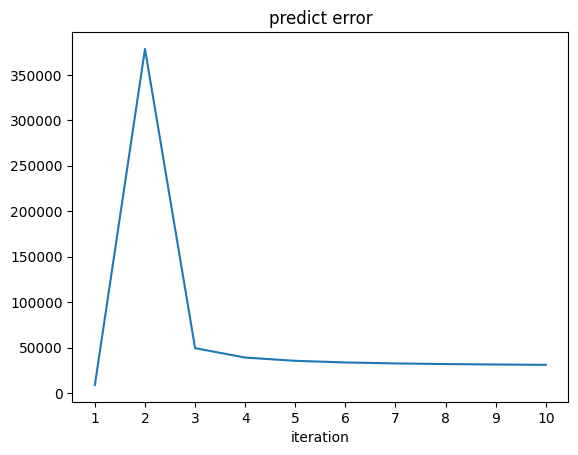

In [ ]:
# predict_errors
x_axis = np.arange(1,11)
y_axis = predict_errors_0
plt.plot(x_axis, y_axis)
plt.xticks([i for i in range(1,11)])
plt.xlabel("iteration")
plt.title("predict error")
plt.show()

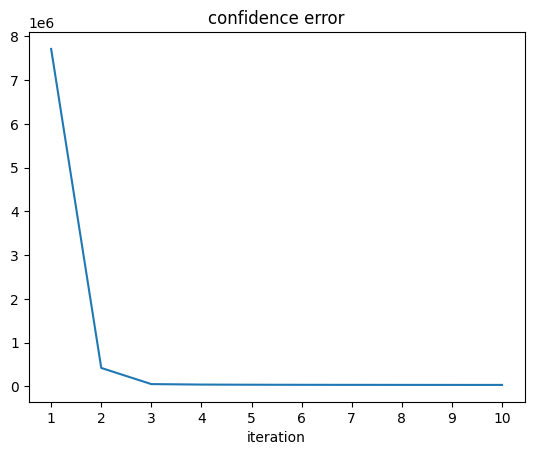

In [ ]:
# confident_errors
x_axis = np.arange(1,11)
y_axis = confident_errors_0
plt.plot(x_axis, y_axis)
plt.xticks([i for i in range(1,11)])
plt.xlabel("iteration")
plt.title("confidence error")
plt.show()

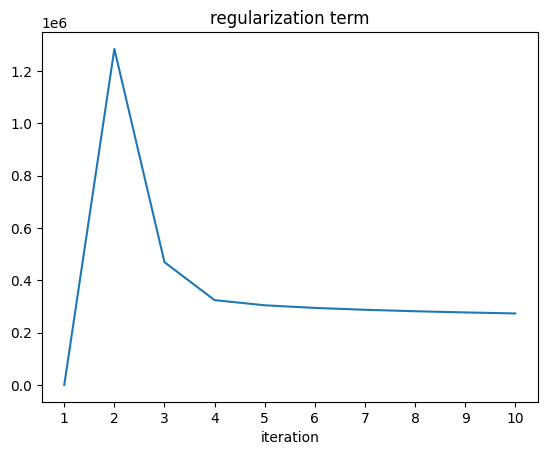

In [ ]:
# regularization_list
x_axis = np.arange(1,11)
y_axis = regularization_list_0
plt.plot(x_axis, y_axis)
plt.xticks([i for i in range(1,11)])
plt.xlabel("iteration")
plt.title("regularization term")
plt.show()

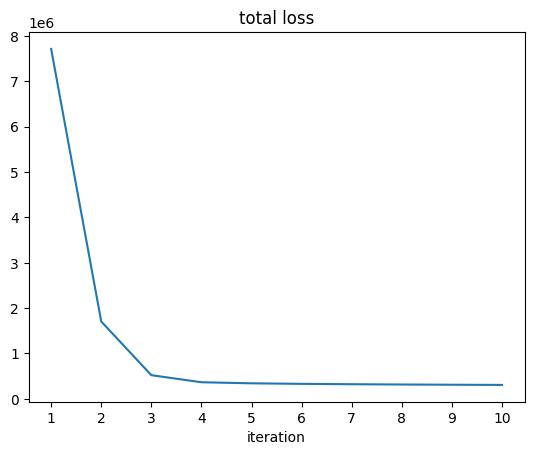

In [ ]:
# total_losses
x_axis = np.arange(1,11)
y_axis = total_losses_0
plt.plot(x_axis, y_axis)
plt.xticks([i for i in range(1,11)])
plt.xlabel("iteration")
plt.title("total loss")
plt.show()

### Experiment2: item-based collaborative filtering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
R_matrix = create_R_matrix(data, train_df)
item_user_matrix = R_matrix.transpose()

In [ ]:
similarity_rate = cosine_similarity(item_user_matrix, item_user_matrix)

In [ ]:
item_sim_df = pd.DataFrame(data=similarity_rate, index=R_matrix.columns, columns=R_matrix.columns)

In [ ]:
def predict_plays(plays_arr, item_sim_arr):
  plays_pred = plays_arr.dot(item_sim_arr) / np.array([np.abs(item_sim_arr).sum(axis=1)])
  return plays_pred

In [ ]:
plays_pred = predict_plays(R_matrix.values, item_sim_df.values)
plays_pred_df = pd.DataFrame(data=plays_pred, index=R_matrix.index, columns=R_matrix.columns)

In [ ]:
plays_pred_df.head()

,!!!,!t.o.o.h.!,(hed) p.e.,(hed) planet earth,*nsync,...and you will know us by the trail of dead,000 maniacs,1 giant leap,"10,000 maniacs",100 flowers,...,Веня Д'ркин,Кино,Кошкин Дом,Макsим,Мельница,СБПЧ Оркестр,Юрий Визбор,周杰倫,坂本龍一,武満徹
1,10.251038,0.076834,0.207561,0.546477,0.0,2.115857,NaN,0.000000,0.617304,0.133228,...,2.144262,3.500043,2.144262,0.013843,0.204349,NaN,0.732377,NaN,0.000000,NaN
2,0.008879,0.000584,0.000000,0.000000,0.0,0.005056,NaN,0.357445,0.016385,0.000000,...,0.030810,0.583479,0.030810,0.007637,0.000000,NaN,0.000771,NaN,0.116302,NaN
3,0.099944,0.000000,0.000000,0.000000,0.0,0.054045,NaN,0.000000,0.006064,0.000000,...,0.000000,0.089291,0.000000,0.027878,0.000000,NaN,0.000000,NaN,0.000000,NaN
4,0.072334,0.749415,3.439008,0.036224,0.0,1.887687,NaN,0.000000,0.184490,4.291952,...,12.691431,0.892071,12.691431,0.000000,0.055369,NaN,0.889712,NaN,0.000000,NaN
5,0.066419,0.426296,0.079813,0.000193,0.0,0.000000,NaN,0.000000,0.009528,1.039258,...,0.000000,2.169040,0.000000,0.455155,1.122780,NaN,0.000000,NaN,0.000000,NaN


In [ ]:
rank_bar_item_neighbor = calculate_rank(plays_pred_df, R_matrix, train_df, test_df)

0.7252196318914802


topN-item based CF

In [ ]:
def predict_plays_topsim(plays_arr, item_sim_arr, n=20):
  pred = np.zeros(plays_arr.shape)
  for col in range(plays_arr.shape[1]):
    top_n_items = [np.argsort(item_sim_arr[:, col])[:-n-1:-1]]
    for row in range(plays_arr.shape[0]):
      pred[row, col] = item_sim_arr[col,:][top_n_items].dot(
          plays_arr[row,:][top_n_items].T)
      pred[row,col] /= np.sum(item_sim_arr[col,:][top_n_items])
  return pred

In [ ]:
plays_pred_topN = predict_plays_topsim(R_matrix.values, item_sim_df.values, n=10)

In [ ]:
plays_pred_topN_df = pd.DataFrame(data=plays_pred_topN, index=R_matrix.index, columns=R_matrix.columns)

In [ ]:
plays_pred_topN_df.head()

,!!!,!t.o.o.h.!,(hed) p.e.,(hed) planet earth,*nsync,...and you will know us by the trail of dead,000 maniacs,1 giant leap,"10,000 maniacs",100 flowers,...,Веня Д'ркин,Кино,Кошкин Дом,Макsим,Мельница,СБПЧ Оркестр,Юрий Визбор,周杰倫,坂本龍一,武満徹
1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
2,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN


In [ ]:
rank_bar_item_neighbor_topN = calculate_rank(plays_pred_topN_df, R_matrix, train_df, test_df)

0.724383532032827
